<a href="https://colab.research.google.com/github/SydanJainen/Cell-image-segmentation/blob/main/image_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL IMAGE SEGMENTATION

## HYPERPARAMETER


In [28]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

BATCH_SIZE = 32
EPOCHS = 10
PADDING = 1
STRIDE = 1

VAL_SPLIT = 0.2
SEED = 23

LEARNING_RATE = 1e-4
EPS = 1e-3

## CHECK IF COLAB OR OFFLINE

In [29]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

## CHECK IF GPU IS AVAILABLE

In [30]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


## REQUIREMENT

In [31]:
if isColab:
  import os
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORTS

In [32]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [33]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


## LOAD DATA

In [34]:
IMAGE_PATH = os.path.join(DB_PATH, "train")
LABEL_PATH = os.path.join(DB_PATH, "label")

# Ensure both directories have the same number of files
number_images = len(os.listdir(IMAGE_PATH))
number_labels = len(os.listdir(LABEL_PATH))

assert number_images == number_labels

# LOAD PIL IMAGES AND LABELS
image_files = sorted(os.listdir(IMAGE_PATH))
label_files = sorted(os.listdir(LABEL_PATH))

# Split into train and temp sets
train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=VAL_SPLIT, random_state=SEED)


AUGMENTATION

## DEFINE DATASET

In [35]:
class CellularDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            label_dir (string): Directory with all the labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.image_files = images
        self.label_files = labels

        # Ensure both directories have the same number of files
        assert len(self.image_files) == len(self.label_files), \
            "The number of images and labels should be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct file paths
        img_name = os.path.join(IMAGE_PATH, self.image_files[idx])
        label_name = os.path.join(LABEL_PATH, self.label_files[idx])

        # Load image and label
        image = Image.open(img_name).convert('RGB')
        label = Image.open(label_name).convert('L')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Convert to NumPy arrays
        image_np = np.array(image)
        label_np = np.array(label)

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(image_np).float()
        label_tensor = torch.from_numpy(label_np).long()

        return image_tensor, label_tensor

DEFINE TRANSFORMATIONS

In [36]:
class CellularTransform:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, **kwargs):
        if random.random() < self.prob:
            params = self.get_params()
            return {k: self.apply(a, **params) if k in self.targets else a for k, a in kwargs.items()}
        return kwargs

    def apply(self, img, **params):
        raise NotImplementedError

    def get_params(self):
        return {}

    @property
    def targets(self):
        # you must specify targets in subclass
        # for example: ('image', 'mask')
        #              ('image', 'boxes')
        raise NotImplementedError

class DualTransform(CellularTransform):
    """
    transfrom for segmentation task
    """
    @property
    def targets(self):
        return 'image', 'mask'

class VerticalFlip(DualTransform):
    def apply(self, img, **params):
        return F.vflip(img)


class HorizontalFlip(DualTransform):
    def apply(self, img, **params):
        return F.hflip(img)


class Flip(DualTransform):
    def apply(self, img, d=0):
        return F.random_flip(img, d)

    def get_params(self):
        return {'d': random.randint(-1, 1)}


class Transpose(DualTransform):
    def apply(self, img, **params):
        return F.transpose(img)

## Create Dataset and Dataloader

In [37]:
train_dataset = CellularDataset(train_images,train_labels)
val_dataset = CellularDataset(val_images,val_labels)

In [38]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


## MODEL

In [39]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

METRICS

## Jaccard Index

The **Jaccard Index**, also known as the **Jaccard Similarity Coefficient**, is defined as the size of the intersection divided by the size of the union of two sets. Mathematically, it is given by:

\J(A, B) = \frac{|A \cap B|}{|A \cup B|}


In the context of binary classification, where $A$ represents the predicted binary values and $B$ represents the ground truth binary values, the Jaccard index can be computed as:

\
J(\mathbf{p}, \mathbf{t}) = \frac{\sum_{i} (p_i \cdot t_i)}{\sum_{i} p_i + \sum_{i} t_i - \sum_{i} (p_i \cdot t_i)}

where $\mathbf{p}$ and $\mathbf{t}$ are the predicted and true values, respectively, and the summation is performed over all elements.

## Jaccard Loss

The **Jaccard Loss** is derived from the Jaccard index and is used as a loss function to optimize models, especially in tasks like image segmentation. It is defined as:

\\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J(\mathbf{p}, \mathbf{t})

where $J(\mathbf{p}, \mathbf{t})$ is the Jaccard index computed between the predicted values $\mathbf{p}$ and the true values $\mathbf{t}$.

\subsection{Weighted Jaccard Index}

In some cases, a weighted version of the Jaccard index might be used to give different importance to different elements:

\J_w(\mathbf{p}, \mathbf{t}, \mathbf{w}) = \frac{\sum_{i} (w_i \cdot p_i \cdot t_i)}{\sum_{i} w_i \cdot (p_i + t_i - p_i \cdot t_i)}

where $\mathbf{w}$ represents the weights.

\subsection{Implementation Details}

To ensure numerical stability, a small constant $\epsilon$ is added to the numerator and denominator:

\
J_{\epsilon}(\mathbf{p}, \mathbf{t}) = \frac{\sum_{i} (p_i \cdot t_i) + \epsilon}{\sum_{i} (p_i + t_i - p_i \cdot t_i) + \epsilon}

The Jaccard loss thus becomes:

\
\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J_{\epsilon}(\mathbf{p}, \mathbf{t})


In [40]:
def jaccard(preds, trues, weight=None, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = (intersection + EPS) / ((preds + trues).sum(1) - intersection + EPS)

    score = scores.sum()
    if is_average:
        score /= num
    return torch.clamp(score, 0., 1.)

def jaccard_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard(preds, trues, is_average=is_average)


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        return jaccard(input, target, self.weight, self.size_average)

In [41]:
def dice_loss(preds, trues, weight=None, is_average=True):
    preds = preds.contiguous()
    trues = trues.contiguous()
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = (2. * intersection + EPS) / (preds.sum(1) + trues.sum(1) + EPS)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

def dice_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        return dice_loss(input, target, self.weight, self.size_average)

## TRAIN

In [42]:
if isColab:
  !pip install tqdm

In [43]:
def save_checkpoint(state, filename="unet_chckpnt.pth.tar"):
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    model.load_state_dict(checkpoint["state_dict"])

In [47]:
from tqdm import tqdm

train_loss = []
val_loss = []

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.permute(0, 3, 1, 2).to(device)  # Transpose to [batch_size, channels, height, width]
        targets = targets.float().unsqueeze(1).to(device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            train_loss.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def check_accuracy(loader, model, loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.permute(0, 3, 1, 2).to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            val_loss.append(loss_fn(preds, y))

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def fit(model, optimizer, loss_fn):
  for epoch in range(EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn)

    # check accuracy
    check_accuracy(val_loader, model, loss_fn, device=device)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

In [48]:
model = UNET(in_channels=3, out_channels=1).to(device)
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = JaccardLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [49]:
fit(model,optimizer,loss_fn)

100%|██████████| 17/17 [00:18<00:00,  1.12s/it, loss=0]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 2.39 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.47 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


Got 5213458/8781824 with acc 59.37
Dice score: 0.9563325047492981


100%|██████████| 17/17 [00:14<00:00,  1.20it/s, loss=0]


Got 7302281/8781824 with acc 83.15
Dice score: 0.45037946105003357


100%|██████████| 17/17 [00:14<00:00,  1.16it/s, loss=0]


Got 7062225/8781824 with acc 80.42
Dice score: 0.3520451486110687


100%|██████████| 17/17 [00:14<00:00,  1.18it/s, loss=0]


Got 6992358/8781824 with acc 79.62
Dice score: 0.33898258209228516


100%|██████████| 17/17 [00:15<00:00,  1.11it/s, loss=0]


Got 7038321/8781824 with acc 80.15
Dice score: 0.32734790444374084


100%|██████████| 17/17 [00:14<00:00,  1.18it/s, loss=0]


Got 6993041/8781824 with acc 79.63
Dice score: 0.33337506651878357


100%|██████████| 17/17 [00:14<00:00,  1.17it/s, loss=0]


Got 6999087/8781824 with acc 79.70
Dice score: 0.3380541503429413


100%|██████████| 17/17 [00:14<00:00,  1.19it/s, loss=0]


Got 7037320/8781824 with acc 80.14
Dice score: 0.33226513862609863


100%|██████████| 17/17 [00:14<00:00,  1.20it/s, loss=0]


Got 7028141/8781824 with acc 80.03
Dice score: 0.3356805443763733


100%|██████████| 17/17 [00:13<00:00,  1.22it/s, loss=0]


Got 7033429/8781824 with acc 80.09
Dice score: 0.3277229964733124


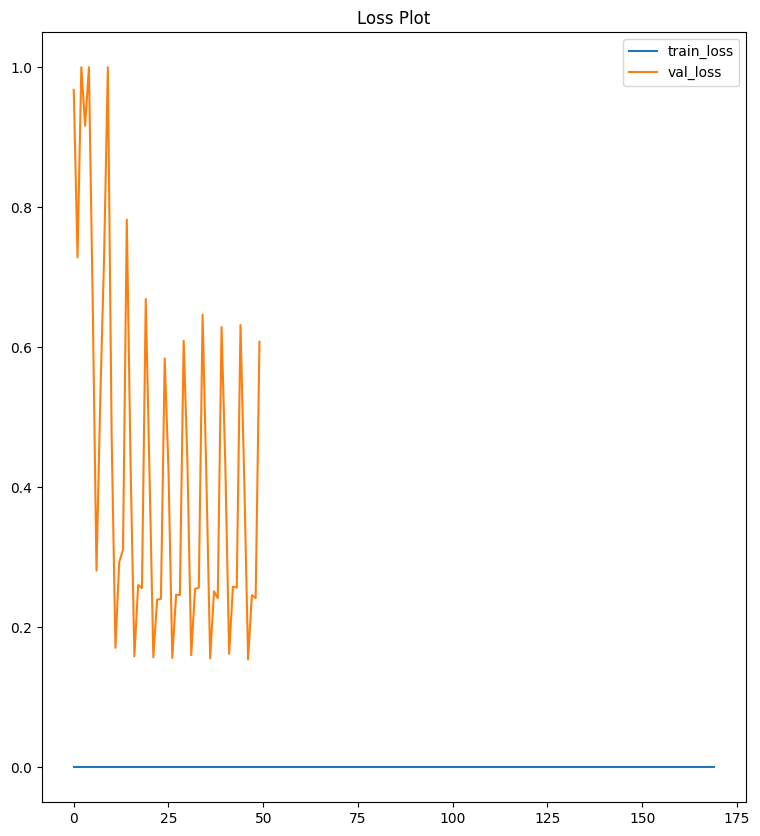

In [58]:
train_loss_cpu = [tensor.cpu().detach().numpy() for tensor in train_loss]
val_loss_cpu = [tensor.cpu().detach().numpy() for tensor in val_loss]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss_cpu, label='train_loss')
plt.plot(val_loss_cpu, label='val_loss')
plt.legend()
plt.title('Loss Plot')

plt.show()

In [59]:

def to_mask(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def to_image(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

In [64]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
image =  image.permute(0, 3, 1, 2).to(device)
print(image)
y_pred = model.forward(image)

plt.figure(figsize=(20,15))
for i in range(0,2):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(to_image(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(to_mask(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(to_mask(y_pred[i]),cmap='gray')
plt.show()

tensor([[[[  5.,   5.,   5.,  ...,   2.,   2.,   3.],
          [  5.,   4.,   5.,  ...,   3.,   3.,   2.],
          [  4.,   4.,   5.,  ...,   3.,   3.,   3.],
          ...,
          [ 37.,  32.,  30.,  ...,  12.,  10.,   9.],
          [ 37.,  31.,  29.,  ...,  12.,  11.,   8.],
          [ 34.,  30.,  26.,  ...,  12.,  11.,   9.]],

         [[  5.,   5.,   5.,  ...,   2.,   2.,   3.],
          [  5.,   4.,   5.,  ...,   3.,   3.,   2.],
          [  4.,   4.,   5.,  ...,   3.,   3.,   3.],
          ...,
          [ 37.,  32.,  30.,  ...,  12.,  10.,   9.],
          [ 37.,  31.,  29.,  ...,  12.,  11.,   8.],
          [ 34.,  30.,  26.,  ...,  12.,  11.,   9.]],

         [[  5.,   5.,   5.,  ...,   2.,   2.,   3.],
          [  5.,   4.,   5.,  ...,   3.,   3.,   2.],
          [  4.,   4.,   5.,  ...,   3.,   3.,   3.],
          ...,
          [ 37.,  32.,  30.,  ...,  12.,  10.,   9.],
          [ 37.,  31.,  29.,  ...,  12.,  11.,   8.],
          [ 34.,  30.,  26.,  ...

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 